<a href="https://colab.research.google.com/github/Diyon335/PRA3024/blob/master/Week3_Gideon/Final_week3_fisherMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercise 1 and 2
This section computes the standard deviation for any observables. The code is generalised as to allow the user to change their Power Spectral Density functions and Waveforms. 

In [0]:
#Import the necessary libraries 
import numpy as np
import cmath as cm
import sympy as sp

In [0]:
#Created an integration and differentiation function
def integral_of(function, low, high, dx):
  area = 0
  x = low
  steps = int((high-low)/dx)
  for i in range(steps):
    area += function(x)*dx
    x+=dx
  return area


In [0]:
#Declare any constants
G = 6.67*10**(-11)
c = 2.998*10**(8)
## PSD ##
f0 = 150
fs = 40 
## Wavefunction h(f) ##
solar_mass = 2*(10**30)
m1 = 2*solar_mass
m2 = 1*solar_mass
M = m1 + m2
SNR = 10
eta = (m1*m2)/(M**2)
tc = 1
phic = 1

#If you want higher PN orders, then add more corrections. But dont forget to add it into the pn_array below
a0 = 1
a1 = 0
a2 = (20/9)*(743/336 + (11/4)*eta)

#The variables with which h(f) will be differentiated wrt
variables = [tc,phic,eta,M]
#change to match with variables
observables= ["tc","phic","eta","M"]

In [0]:
#If any more corrections are added above, then add them to this array
pn_array = [a0,a1,a2]

In [0]:
#This is the function for the phase, xi(f)
def xi(f):
  summed_function = 0
  v = (((float(sp.pi))*M*f)**(1/3))
  for j in range(0, len(pn_array)):
    summed_function += pn_array[j]*(v**(j))
  return 2*float(sp.pi)*f*tc - phic - float(sp.pi)/4 + (3/(128*eta*(v**5)))*summed_function

In [0]:
#Here you can initialise any PSD function
#This is for the Initial LIGO / the fs and f0 are initialised above
def s_f(f):
  S0 = 9*10**(-46)
  x = f/f0
  if f >= fs:
    return S0*((4.49*x)**(-5) + (0.16*x)**(-4.52) + 0.52 + (0.32*x)**2 )
  if f < fs:
    return 100000000000 #infinity

In [0]:
#The waveform and its conjugate
def h_real(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(1j*xi_f)

def h_compl(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(-1j*xi_f)

In [0]:
#This returns the derivative of the real and complex waveforms respectively 
def d_h_real(i,inc):
  return (h_real(variables[i]+inc) - h_real(variables[i])) / inc
def d_h_compl(j,inc):
  return (h_compl(variables[j]+inc) - h_compl(variables[j])) / inc

Unfortunately, due to errors when computing any values OTHER than the diagonals, only the diagonal elements were computed. Weather this affected any results is unknown due to the lack of understanding of theory. Sorry if that is the case!

In [0]:
def create_fm(matrix, increment):
  #This part here creates the range of frequencies to integrate from
  frequencies = np.zeros(shape=(len(variables)*len(variables)))
  start_freq = fs
  f_steps = int(  (f0-fs)  /  (len(variables)*len(variables))    )
  for s in range(len(variables)*len(variables)):
    frequencies[s] = start_freq
    start_freq += f_steps
  
  f_index = 0
  intg = 0
  #print(frequencies)
  for i in range(len(variables)):
    for j in range(len(variables)):
      if i==j:
        numerator = 4 * float(d_h_real(i, increment) * d_h_compl(j, increment))
        intg += numerator/np.real(s_f(frequencies[f_index]))*increment
        matrix[i][j] = intg
      f_index += 1
  
  return matrix

In [14]:
#Create a matrix for the values to go into
fm = np.zeros( shape=(len(variables),len(variables)) )

create_fm(fm, 0.01)
print(fm)

[[1.82694170e+77 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.47490703e+78 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.98154982e+80 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.98154982e+80]]


In [0]:
#This function will compute the standard deviation of measuring observables (tc, phic, eta, M)
def compute_stds(matrix):
  inverse = np.linalg.inv(matrix)
  diag_elements = []
  for i in range(len(variables)):
    for j in range(len(variables)):
      if (i==j):
        diag_elements.append(inverse[i][j])
  for k in range(len(diag_elements)):
    diag_elements[k] = np.sqrt(diag_elements[k])

  for l in range(len(diag_elements)):
    print("The standard deviation for {} is {}".format(observables[l],diag_elements[l]))



Note: The following values of standard deviation are computed without accounting for the value of c and G. The following values set c = G = 1

In [16]:
compute_stds(fm)

The standard deviation for tc is 2.3395786802596237e-39
The standard deviation for phic is 6.3565366507702305e-40
The standard deviation for eta is 4.0887742972236405e-41
The standard deviation for M is 4.0887742972236405e-41


## Exercise 3
The function used to create the Fisher matrix will be modified to read PSD files. After doing so, it will be tested with a new observable, M_chirp, rather than total mass, M


In [0]:
import urllib.request as r

In [0]:
#Change these to access the files you want
name = "advancedLigo.txt"
#The arrays onto which Frequencies and Sensitivities must be loaded to to plot the graphs
x = []
y = []

#Define our new variables/Constants
M_chirp = M*eta**(3/5)
fs = 20
f0 = 215

variables = [tc,phic,eta,M_chirp]

observables= ["tc","phic","eta","M_chirp"]

In [0]:
#Define our new PSD for the advanced LIGO
def s_f_aLigo(f):
  S0 = 10**(-49)
  x = f/f0
  if f >= fs:
    return S0*(x**(-4.14) - 5*x**(-2) + (111*(1 - x**2 - (x**4) / 2))/(1 + (x**2) / 2))
  if f < fs:
    return 100000000000 #infinity

In [0]:
#The waveform and its conjugate
def h_real(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f_aLigo,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(1j*xi_f)

def h_compl(f):
  A = sp.sqrt(  SNR/ (4* integral_of(s_f_aLigo,fs,f0,0.01) ) )
  xi_f = xi(f)
  return A*f**(-7/6)*sp.exp(-1j*xi_f)

In [0]:
#This function opens the file you want and returns two arrays of values: the frequencies and their respective sensitvities 
def loaddata(name, x, y):
  try:
    f = open(name,"r")
    firstline = f.readline()
    columns = len(firstline.split())
    #to re-read
    f.seek(0)

    lines = f.readlines()
    for l in lines:
      x.append(l.split()[0])
      y.append(l.split()[columns - 1])
    
    f.close()
    
  except:
    print("Please place the file you want to read in your directory!")

In [0]:
#We have to modify our previous function to create a Fisher Matrix
def create_fm_new(matrix, increment, name = False):
  
  frequencies = []
  f_index = 0
  intg = 0
  
  if(name==False):
    #This part here creates the range of frequencies to integrate from
    for n in range(len(variables)*len(variables)):
      frequencies.append(0)
    start_freq = fs
    f_steps = int(  (f0-fs)  /  (len(variables)*len(variables))    )
    for s in range(len(variables)*len(variables)):
      frequencies[s] = start_freq
      start_freq += f_steps
    
    for i in range(len(variables)):
      for j in range(len(variables)):
        if i==j:
          numerator = 4 * float(d_h_real(i, increment) * d_h_compl(j, increment))
          intg += numerator/np.real(s_f(frequencies[f_index]))*increment
          matrix[i][j] = intg
        f_index += 1

  elif(name!=False):
    freqs = []
    sens = []
    loaddata(name, freqs, sens)
    s = 0
    for a in range(len(variables)):
      for b in range(len(variables)):
        for f in range(len(sens)):
          s += float(sens[f])
        if a==b:  
          numerator = 4 * float(d_h_real(a, increment) * d_h_compl(b, increment))
          intg += numerator/np.real(s)*increment
          matrix[a][b] = intg
          s=0

  return matrix

In [151]:
#Create a new matrix 

new_fm = np.zeros(shape=(len(variables),len(variables)))

create_fm_new(new_fm, 0.01,name = name)

array([[2.21220658e+63, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.65464790e+63, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.55878639e+64, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.55878639e+64]])

In [152]:
compute_stds(new_fm)

The standard deviation for tc is 2.1261169982407398e-32
The standard deviation for phic is 1.9408703997193754e-32
The standard deviation for eta is 6.25148197861847e-33
The standard deviation for M_chirp is 6.25148197861847e-33


['9.000000e+00', '9.020400e+00', '9.040846e+00', '9.061338e+00', '9.081877e+00', '9.102462e+00', '9.123094e+00', '9.143773e+00', '9.164499e+00', '9.185272e+00', '9.206091e+00', '9.226958e+00', '9.247872e+00', '9.268834e+00', '9.289843e+00', '9.310900e+00', '9.332005e+00', '9.353157e+00', '9.374357e+00', '9.395605e+00', '9.416902e+00', '9.438247e+00', '9.459640e+00', '9.481082e+00', '9.502572e+00', '9.524111e+00', '9.545698e+00', '9.567335e+00', '9.589021e+00', '9.610756e+00', '9.632540e+00', '9.654373e+00', '9.676256e+00', '9.698189e+00', '9.720171e+00', '9.742204e+00', '9.764286e+00', '9.786418e+00', '9.808600e+00', '9.830833e+00', '9.853116e+00', '9.875449e+00', '9.897833e+00', '9.920268e+00', '9.942754e+00', '9.965291e+00', '9.987878e+00', '1.001052e+01', '1.003321e+01', '1.005595e+01', '1.007874e+01', '1.010159e+01', '1.012448e+01', '1.014743e+01', '1.017043e+01', '1.019349e+01', '1.021659e+01', '1.023975e+01', '1.026296e+01', '1.028622e+01', '1.030954e+01', '1.033290e+01', '1.0356

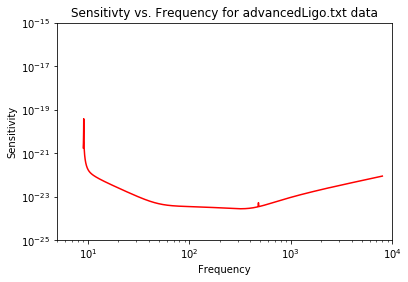

In [153]:
#Now to plot the freqs of the advanced Ligo data against the sensitivities 
import matplotlib.pyplot as plt

x_axis = []
y_axis = []

loaddata(name, x_axis,y_axis )
print(x_axis)
print(y_axis)
for i in range(len(x_axis)):
  x_axis[i] = float(x_axis[i])
  y_axis[i] = float(y_axis[i])


plt.figure()
plt.title("Sensitivty vs. Frequency for {} data".format(name))
plt.xlabel("Frequency")
plt.ylabel("Sensitivity")
plt.xscale("log")
plt.yscale("log")
axes = plt.gca()
axes.set_xlim(5, 10**4)
axes.set_ylim(10**(-25), 10**(-15))

plt.plot(x_axis,y_axis,color = 'r', linestyle = '-')
plt.show()


['1.0000000e+00', '1.0030759e+00', '1.0061612e+00', '1.0092560e+00', '1.0123603e+00', '1.0154742e+00', '1.0185976e+00', '1.0217307e+00', '1.0248734e+00', '1.0280258e+00', '1.0311878e+00', '1.0343596e+00', '1.0375412e+00', '1.0407325e+00', '1.0439336e+00', '1.0471446e+00', '1.0503655e+00', '1.0535963e+00', '1.0568370e+00', '1.0600877e+00', '1.0633483e+00', '1.0666191e+00', '1.0698998e+00', '1.0731907e+00', '1.0764917e+00', '1.0798028e+00', '1.0831241e+00', '1.0864557e+00', '1.0897974e+00', '1.0931495e+00', '1.0965119e+00', '1.0998846e+00', '1.1032677e+00', '1.1066612e+00', '1.1100651e+00', '1.1134795e+00', '1.1169044e+00', '1.1203398e+00', '1.1237859e+00', '1.1272425e+00', '1.1307097e+00', '1.1341876e+00', '1.1376762e+00', '1.1411755e+00', '1.1446856e+00', '1.1482065e+00', '1.1517382e+00', '1.1552808e+00', '1.1588343e+00', '1.1623987e+00', '1.1659741e+00', '1.1695605e+00', '1.1731579e+00', '1.1767663e+00', '1.1803859e+00', '1.1840166e+00', '1.1876585e+00', '1.1913115e+00', '1.1949758e+0

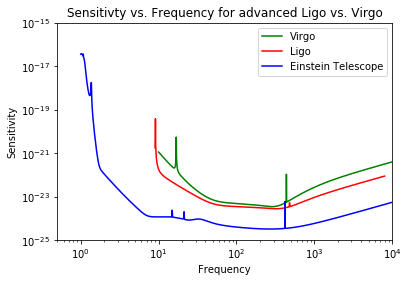

In [160]:
#Now to compare the graphs for advanced Ligo, Virgo and Einstein

new_x = []
new_y = []
e_x = []
e_y = []

loaddata("advancedVirgo.txt", new_x,new_y )
loaddata("einstein.txt", e_x,e_y)
print(e_x)
print(e_y)

for i in range(len(new_x)):
  new_x[i] = float(new_x[i])
  new_y[i] = float(new_y[i])

for m in range(len(e_x)):
  e_x[m] = float(e_x[m])
  e_y[m] = float(e_y[m])

plt.figure()
plt.title("Sensitivty vs. Frequency for advanced Ligo vs. Virgo")
plt.xlabel("Frequency")
plt.ylabel("Sensitivity")
plt.xscale("log")
plt.yscale("log")
axes = plt.gca()
axes.set_xlim(0.5, 10**4)
axes.set_ylim(10**(-25), 10**(-15))

plt.plot(new_x,new_y,color='g',linestyle='-',label='Virgo')
plt.plot(x_axis,y_axis,color = 'r', linestyle = '-',label='Ligo')
plt.plot(e_x,e_y,color='b',linestyle='-',label="Einstein Telescope")
plt.legend()
plt.show()